<a href="https://colab.research.google.com/github/anirbanghoshsbi/.github.io/blob/master/Stacking_classification_with_trend_following_class_labels(Working).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification (with class labels)
***

# Import

In [152]:
!pip install vecstack==0.4.0
!pip install yfinance --upgrade --no-cache-dir
#!pip install -U scikit-learn==1.0

In [153]:
!pip install pandas-ta==0.2.45b

In [154]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from vecstack import stacking
import yfinance as yf
import numpy as np
import pandas as pd
import pandas_ta as ta
from pandas_datareader import data as pdr
START = "2015-01-01"  #yyyy-mm-dd
END = '2020-12-01'

In [155]:
trend_decider ='percentchange' #'percentchange' #'impulse' # 'sma'#'long' # percentchange
period=10
days_out=30

# Prepare data

In [156]:
tker = '^nsei' #'^nsei'
nifty =yf.download(tker,start=START,end=END)
#nifty=quandl.get('BSE/BOM500112',start_date=START,end_date=END,authtoken='1Mz3xLNFNdUpKENCkArB')
#nifty = pdr.get_data_yahoo(tker, start=START, end=END)
nifty=nifty.dropna()
nifty=nifty.iloc[:,:4]

[*********************100%***********************]  1 of 1 completed


In [157]:
nifty.columns

Index(['Open', 'High', 'Low', 'Close'], dtype='object')

In [158]:
# Calculate 30 Day Moving Average, Std Deviation, Upper Band and Lower Band

nifty['30 Day MA'] = nifty['Close'].rolling(window=20).mean()

# set .std(ddof=0) for population std instead of sample
nifty['30 Day STD'] = nifty['Close'].rolling(window=20).std() 
nifty['Upper Band'] = nifty['30 Day MA'] + (nifty['30 Day STD'] *1.5)
nifty['Lower Band'] = nifty['30 Day MA'] - (nifty['30 Day STD'] *1.5)
nifty['ADV_26'] = nifty['Close'].rolling(window=26).mean()
nifty['ADV_13'] = nifty['Close'].rolling(window=10).mean()
nifty['ADV_50'] = nifty['Close'].rolling(window=50).mean()
nifty.ta.macd(append=True)
nifty.ta.vortex(period=18,append=True)
nifty.ta.aroon(period=18,append=True)
print()

In [159]:
df_old = nifty.copy()
# I Just need the Close
price_data = df_old.copy()

In [160]:
features = ['30 Day MA','30 Day STD','Upper Band','Lower Band','ADV_26','ADV_13','ADV_50','MACD_12_26_9',\
       'MACDh_12_26_9', 'MACDs_12_26_9','VTXP_14', 'VTXM_14','AROONU_14', 'AROONOSC_14']

In [161]:
price_data.columns

Index(['open', 'high', 'low', 'close', '30 Day MA', '30 Day STD', 'Upper Band',
       'Lower Band', 'ADV_26', 'ADV_13', 'ADV_50', 'MACD_12_26_9',
       'MACDh_12_26_9', 'MACDs_12_26_9', 'VTXP_14', 'VTXM_14', 'AROOND_14',
       'AROONU_14', 'AROONOSC_14'],
      dtype='object')

#####df = df.assign(flag=df['apm'].gt(df['apm'].shift()))

In [162]:
if trend_decider=='impulse':
  price_data=price_data.assign(Flag=(price_data['MACDh_12_26_9'].lt(price_data['MACDh_12_26_9'].shift()) & price_data['ADV_13'].lt(price_data['ADV_13'].shift())))
elif trend_decider=='sma':
  price_data= price_data.assign(Flag=price_data['ADV_50'].lt(price_data['ADV_50'].shift()))
elif trend_decider=='long':
  price_data= price_data.assign(Flag=price_data['ADV_50'].lt(price_data['ADV_50'].shift(period))) 
elif trend_decider=='percentchange':
  close_groups = price_data['close'].transform(lambda x : np.sign(x.diff(days_out)))
  price_data['Flag'] = close_groups  

In [163]:
price_data=price_data.assign(Strength_Flag=(price_data['MACDh_12_26_9'].gt(price_data['MACDh_12_26_9'].shift()) & price_data['ADV_13'].lt(price_data['ADV_13'].shift()) | (price_data['MACDh_12_26_9'].lt(price_data['MACDh_12_26_9'].shift()) & price_data['ADV_13'].gt(price_data['ADV_13'].shift()))))

In [164]:
price_data.dropna(inplace=True)

In [165]:
price_data.Strength_Flag.value_counts()
price_data.Strength_Flag = price_data.Strength_Flag.replace({True: 1, False: 40})

In [166]:
X_Cols = price_data[features]
Y_Cols = price_data['Flag']
samp_train= int(len(price_data)*.75) -100
samp_test= samp_train+100
X_train = X_Cols[:samp_train]
X_test = X_Cols[samp_test:]
y_train = Y_Cols[:samp_train]
y_test = Y_Cols[samp_test:]

# Initialize 1st level models

In [167]:
sample_w=price_data[:samp_train].Strength_Flag.values

In [168]:
models_L1 = [
    LogisticRegression(max_iter=400),   
    svm.SVC(kernel='linear'),      
    ExtraTreesClassifier(random_state=0, n_jobs=-1,
                         n_estimators=100, max_depth=3,class_weight='balanced' ),
        
    RandomForestClassifier(random_state=0, n_jobs=-1, 
                           n_estimators=200, max_depth=3,class_weight='balanced'),
          
]

In [169]:
'''XGBClassifier(random_state=0, n_jobs=-1, learning_rate=0.1,sample_weight=sample_w,
                  n_estimators=100, max_depth=3)'''

'XGBClassifier(random_state=0, n_jobs=-1, learning_rate=0.1,sample_weight=sample_w,\n                  n_estimators=100, max_depth=3)'

In [170]:
model_L1_0 = models_L1[0]
_ = model_L1_0.fit(X_train, y_train)
# save model in file if you need

model_L1_1 = models_L1[1]
_ = model_L1_1.fit(X_train, y_train,sample_weight=sample_w)
# save model in file if you need

model_L1_2 = models_L1[2]
_ = model_L1_2.fit(X_train, y_train,sample_weight=sample_w)
# save model in file if you need

model_L1_3 = models_L1[3]
_ = model_L1_3.fit(X_train, y_train)
# save model in file if you need


# Perform stacking

In [171]:
S_train, S_test = stacking(models_L1,                     # list of models
                           X_train, y_train, X_test,   # data
                           regression=False,           # classification task (if you need 
                                                       #     regression - set to True)
                           mode='oof',                 # mode: oof for train set, predict test 
                                                       #mode='oof_pred_bag'(for training) and oof for inference
                                                      #     set in each fold and vote
                           needs_proba=False,          # predict class labels (if you need 
                                                       #     probabilities - set to True) 
                           save_dir=None,              # do not save result and log (to save 
                                                       #     in current dir - set to '.')
                           metric=accuracy_score,      # metric: callable
                           n_folds=4,                  # number of folds
                           stratified=True,            # stratified split for folds
                           shuffle=False,               # shuffle the data
                           random_state=None,             # ensure reproducibility
                           verbose=2)                  # print all info

task:         [classification]
n_classes:    [2]
metric:       [accuracy_score]
mode:         [oof]
n_models:     [4]

model  0:     [LogisticRegression]
    fold  0:  [0.90756303]
    fold  1:  [0.95798319]
    fold  2:  [0.89873418]
    fold  3:  [0.88607595]
    ----
    MEAN:     [0.91258909] + [0.02729831]
    FULL:     [0.91263158]

model  1:     [SVC]
    fold  0:  [0.86134454]
    fold  1:  [0.95798319]
    fold  2:  [0.89029536]
    fold  3:  [0.76371308]
    ----
    MEAN:     [0.86833404] + [0.06984567]
    FULL:     [0.86842105]

model  2:     [ExtraTreesClassifier]
    fold  0:  [0.67226891]
    fold  1:  [0.87394958]
    fold  2:  [0.84810127]
    fold  3:  [0.83122363]
    ----
    MEAN:     [0.80638585] + [0.07891341]
    FULL:     [0.80631579]

model  3:     [RandomForestClassifier]
    fold  0:  [0.63025210]
    fold  1:  [0.84033613]
    fold  2:  [0.89029536]
    fold  3:  [0.88185654]
    ----
    MEAN:     [0.81068503] + [0.10587542]
    FULL:     [0.81052632]



# Look at the result

So now we have OOF from 1st level models and we can build 2nd level model.  
But first let's look at the result.  
We have three 1st level models, so we expect to get three columns in `S_train` and `S_test`.  

In [172]:
S_train[:5]

array([[ 1,  1,  1,  1],
       [ 1,  1, -1,  1],
       [ 1,  1, -1, -1],
       [-1,  1, -1, -1],
       [-1, -1, -1, -1]])

# Apply 2nd level model

In [173]:
# Initialize 2nd level model
model_L2 = XGBClassifier(random_state=0, n_jobs=-1, learning_rate=0.1, 
                      n_estimators=100, max_depth=3)
    
# Fit 2nd level model
_ = model_L2.fit(S_train, y_train)
# Predict
#y_pred = model_L2.predict(S_test)

# Final prediction score
#print('Final prediction score: [%.8f]' % accuracy_score(y_test, y_pred))

In [174]:
# UNDER PRODUCTION
def data_meta(id, x, y, dummy):
  #get prediction from model 1
  #pred_prob_meta = model.predict_proba(x)[:,1]
  pred_prob_meta = pd.Series(dummy, \
  index=x.index,
  name=f'pred_{id}_meta')
  pred_int_meta = pred_prob_meta > Threshold
  y_meta = pd.Series(y & pred_int_meta, name=f'y_train_meta_{id}')
  x_meta = x.join(pred_int_meta)
  return x_meta, y_meta

# Make Predictions

In [175]:
START='2021-02-01'

In [176]:
nifty_test=yf.download(tker,start=START)

[*********************100%***********************]  1 of 1 completed


In [177]:
#nifty_test = pdr.get_data_yahoo(tker, start=START)
nifty_test=nifty_test.dropna()
nifty_test=nifty_test.iloc[:,:4]

In [178]:
# Calculate 30 Day Moving Average, Std Deviation, Upper Band and Lower Band

nifty_test['30 Day MA'] = nifty_test['Close'].rolling(window=20).mean()

# set .std(ddof=0) for population std instead of sample
nifty_test['30 Day STD'] = nifty_test['Close'].rolling(window=20).std() 

nifty_test['Upper Band'] = nifty_test['30 Day MA'] + (nifty_test['30 Day STD'] *1.5)
nifty_test['Lower Band'] = nifty_test['30 Day MA'] - (nifty_test['30 Day STD'] *1.5)
nifty_test['ADV_26'] = nifty_test['Close'].rolling(window=26).mean()
nifty_test['ADV_13'] = nifty_test['Close'].rolling(window=10).mean()
nifty_test['ADV_50'] = nifty_test['Close'].rolling(window=50).mean()
nifty_test.ta.macd(append=True)
nifty_test.ta.vortex(period=18,append=True)
nifty_test.ta.aroon(period=18,append=True)
df = nifty_test.copy()
# I Just need the Close
price_data_new = df.copy()

price_data_new.head(2)

,open,high,low,close,30 Day MA,30 Day STD,Upper Band,Lower Band,ADV_26,ADV_13,ADV_50,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,VTXP_14,VTXM_14,AROOND_14,AROONU_14,AROONOSC_14
date,,,,,,,,,,,,,,,,,,,
2021-02-01,13758.599609,14336.349609,13661.750000,14281.200195,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-02-02,14481.099609,14731.700195,14469.150391,14647.849609,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [179]:
# Group by the `Symbol` column, then grab the `Close` column.
#close_groups = price_data_new['Close']

# Apply the lambda function which will return -1.0 for down, 1.0 for up and 0.0 for no change.
#close_groups = close_groups.transform(lambda x : np.sign(x.diff(days_out)))

# add the data to the main dataframe.
#price_data_new['Prediction'] = close_groups
price_data_new = price_data_new.dropna()

X_Cols = price_data_new[features]
#Y_Cols = price_data_new['Prediction']

X_test_new = X_Cols


In [180]:
#[4] Then new test set (X_test_new) comes. We load our 1st level models and predict new test set to get stacked features (S_test_new):

y_pred_L1_0 = model_L1_0.predict(X_test_new)
y_pred_L1_1 = model_L1_1.predict(X_test_new)
y_pred_L1_2 = model_L1_2.predict(X_test_new)
y_pred_L1_3 = model_L1_3.predict(X_test_new)
S_test_new = np.c_[y_pred_L1_0, y_pred_L1_1,y_pred_L1_2,y_pred_L1_3]
#[5] Then we load our 2nd level model and predict S_test_new to get final prediction:

y_pred_new = model_L2.predict(S_test_new)


In [181]:
y_pred_new_p = model_L2.predict_proba(S_test_new)

In [182]:
y_pred_new_p=max(y_pred_new_p[-1].tolist())*100
print(f'The Probability of the confident class is {round(y_pred_new_p,3)}% ')

The Probability of the confident class is 90.011% 


In [183]:
if trend_decider=='impulse':
  price_data_new=price_data_new.assign(Flag=(price_data_new['MACDh_12_26_9'].lt(price_data_new['MACDh_12_26_9'].shift(1)) & price_data_new['ADV_13'].lt(price_data_new['ADV_13'].shift(1))))
elif trend_decider=='sma':  
  price_data_new= price_data_new.assign(Flag=price_data_new['ADV_50'].lt(price_data_new['ADV_50'].shift()))
elif trend_decider=='long':
  price_data_new= price_data_new.assign(Flag=price_data_new['ADV_50'].lt(price_data_new['ADV_50'].shift(period)))
elif trend_decider=='percentchange':
  close_groups = price_data_new['close'].transform(lambda x : np.sign(x.diff(days_out)))
  price_data_new['Flag'] = close_groups
  price_data_new.dropna(inplace=True)

In [184]:
price_data_new=price_data_new.assign(Strength_Flag=(price_data_new['MACDh_12_26_9'].gt(price_data_new['MACDh_12_26_9'].shift()) & price_data_new['ADV_13'].lt(price_data_new['ADV_13'].shift()) | (price_data_new['MACDh_12_26_9'].lt(price_data_new['MACDh_12_26_9'].shift()) & price_data_new['ADV_13'].gt(price_data_new['ADV_13'].shift()))))

In [185]:
price_data_new.Strength_Flag = price_data_new.Strength_Flag.replace({True: 1, False: 1 })

In [186]:
price_data_new.shape

(146, 21)

In [187]:
if trend_decider !='percentchange':
  price_data_new.Flag = price_data_new.Flag.replace({True: 0, False: 1})
  y_pred_new=y_pred_new.astype(int)
  indices_one = y_pred_new == 1
  indices_zero = y_pred_new == 0
  y_pred_new[indices_one] = 0 # replacing 1s with 0s
  y_pred_new[indices_zero] = 1 # replacing 0s with 1s
if trend_decider =='percentchange':
  #price_data_new.Flag = np.where(price_data_new.close>price_data_new.close.shift(1),1,-1)
  print('done')

done


In [188]:
actuals=price_data_new['Flag'].dropna()
actuals.value_counts()

 1.0    115
-1.0     31
Name: Flag, dtype: int64

In [189]:
np.where(np.isinf(price_data_new['Flag']))

(array([], dtype=int64),)

In [190]:
price_data_new = price_data_new.fillna(lambda x: x.median())
price_data_new = price_data_new.replace({0:1})

In [191]:
y_pred_new= y_pred_new[-len(price_data_new.Flag):]

In [192]:
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(price_data_new['Flag'],y_pred_new)

In [193]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

rf_matrix = confusion_matrix(price_data_new.Flag, y_pred_new)

true_negatives = rf_matrix[0][0]
false_negatives = rf_matrix[1][0]
true_positives = rf_matrix[1][1]
false_positives = rf_matrix[0][1]


In [194]:

accuracy = (true_negatives + true_positives) / (true_negatives + true_positives + false_negatives + false_positives)
percision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
specificity = true_negatives / (true_negatives + false_positives)
f1score= 2*recall*percision/(percision+recall)
print('Accuracy: {}'.format(float(accuracy)))
print('Percision: {}'.format(float(percision)))
print('Recall: {}'.format(float(recall)))
print('Specificity: {}'.format(float(specificity)))
print('F1-Score: {}'.format(float(f1score)))
print('Average Precision : {}'.format(float(average_precision)))


Accuracy: 0.9794520547945206
Percision: 0.9745762711864406
Recall: 1.0
Specificity: 0.9032258064516129
F1-Score: 0.9871244635193133
Average Precision : 0.9745762711864406


In [195]:
buy= np.where(y_pred_new==1)
sell= np.where(y_pred_new==-1) #0 if impulse !!!
b_a=np.where(price_data_new.Flag.values==1)
s_a=np.where(price_data_new.Flag.values==0)

In [196]:
buy=buy[0].tolist()
sell=sell[0].tolist()

In [197]:
buy[-1]

117

In [198]:
len(y_pred_new)

146

In [199]:
len(price_data_new)

146

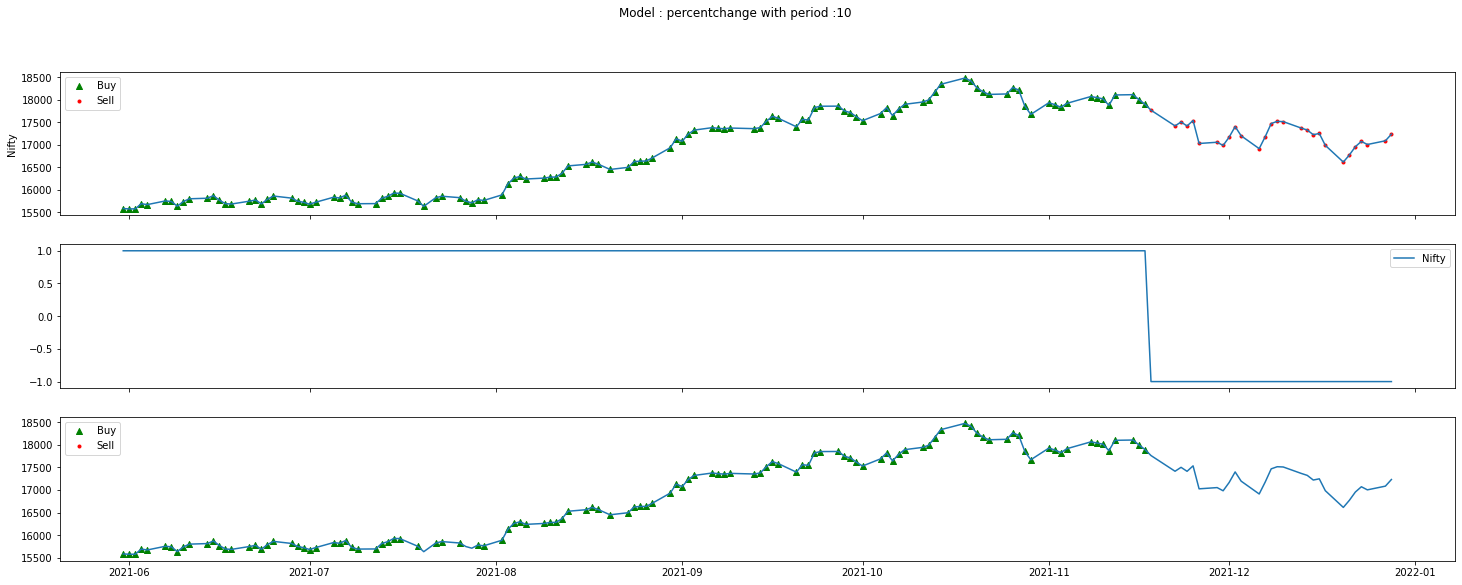

In [200]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(3,1, figsize=(25,9),sharex=True)
ax[0].plot(price_data_new.loc[:, :].index, price_data_new.loc[:, 'close'])
ax[1].plot(price_data_new.loc[:, :].index, y_pred_new, label='Nifty')
ax[0].scatter(price_data_new.iloc[buy].index,price_data_new.iloc[buy].close,marker='^',label='Buy',color='g')
ax[0].scatter(price_data_new.iloc[sell].index,price_data_new.iloc[sell].close,marker='.',label='Sell',color='r')
ax[2].plot(price_data_new.loc[:, :].index, price_data_new.loc[:, 'close'])
ax[2].scatter(price_data_new.iloc[b_a].index,price_data_new.iloc[b_a].close,marker='^',label='Buy',color='g')
ax[2].scatter(price_data_new.iloc[s_a].index,price_data_new.iloc[s_a].close,marker='.',label='Sell',color='r')

ax[0].legend(loc='upper left')
ax[0].set_ylabel('Nifty')
ax[1].legend('ML Signal')
ax[1].legend(loc='best')
ax[2].legend('Nifty')
ax[2].legend(loc='upper left')
fig.suptitle('Model : '+ trend_decider +' with period :' + str(period))

plt.show()


In [201]:
print(f'The Probability of the confident class is {round(y_pred_new_p,3)}%')

The Probability of the confident class is 90.011%
